In [4]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
sys.path.append('..')
from utils import display_video

El siguiente código demuestra cómo crear e interactuar con el entorno CartPole-v1 de OpenAI Gym.

In [5]:
# Crea una instancia del entorno CartPole-v1
env = gym.make("CartPole-v1", render_mode="rgb_array")

El entorno CartPole forma parte del grupo de control clásico, y su objetivo principal es manejar una plataforma con una vara unida a su base. El reto consiste en mantener la vara equilibrada, ya que puede caer hacia la derecha o hacia la izquierda. Para conservar el equilibrio, es necesario mover la plataforma a la derecha o a la izquierda en cada paso.

/opt/anaconda3/envs/rl/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


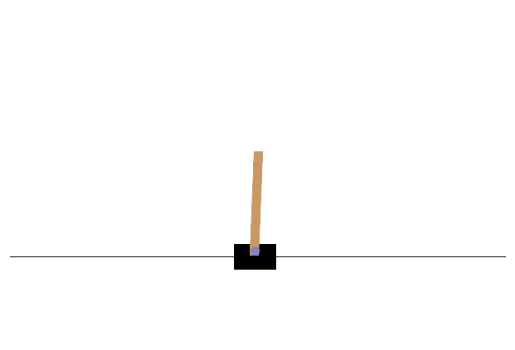

In [6]:
env.reset() 

# Render and display
img = env.render()
plt.imshow(img)
plt.axis('off')
plt.show()

## La observación

### Debemos preguntarnos la naturaleza general de la observación

1. **¿Continua** o **discreta**?
2. **¿Escalar**, **vector** o **tensor**?
3. **¿Rango** de los elementos?
4. **¿Tipo de dato en Python** de los elementos?

In [7]:
obs, info = env.reset()
print(f"Observation: {obs}")
print(f"Info: {info}")

Observation: [ 0.00090628 -0.03375258  0.00042793 -0.00560288]
Info: {}


### `env.observation_space` responde a las preguntas anteriores

In [10]:
print(env.observation_space)

Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


- `Box`: tipo de dato de `gym` que describe arreglos de `numpy` con elementos que toman valores de manera continua dentro de un rango.

| Pregunta | Respuesta |
| --- | --- |
| ¿Continua o discreta? | `Box` $\implies$ continua |
| ¿Escalar, vector o tensor? | `(4,)` $\implies$ vector con 4 dimensiones |
| ¿Rango de los elementos? | rango inferior: `[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]` y rango superior: `[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]` |
| ¿Tipo de dato en Python de los elementos? | `np.float32` |

### Documentación

1. [Environment page in Gymnasium's website](https://gymnasium.farama.org/environments/classic_control/cart_pole/)


<img src="images/obs_desc.jpg" width="750"/>

# Las acciones

Una vez que obtenemos una observación del estado, el siguiente paso es realizar una acción.


Debemos preguntarnos la naturaleza general de las acciones

1. **¿Continuas** o **discretas**?  
2. **¿Escalar**, **vector** o **tensor**?  
3. **¿Rango** de los elementos?  
4. **¿Tipo de dato en Python** de los elementos?  

In [6]:
print(env.action_space)

Discrete(2)


- `Discrete` es un tipo de dato de `gym` que representa una **secuencia de enteros**, comenzando desde cero.

| Pregunta | Respuesta |
| --- | --- |
| ¿Continua o discreta? | `Discrete` $\implies$ discreta |
| ¿Escalar, vector o tensor? | `Discrete` $\implies$ entero $\implies$ escalar |
| ¿Rango de los elementos? | `Discrete(2)` $\implies$ valores permitidos: `0` y `1` |
| ¿Tipo de dato en Python de los elementos? | `int` |

El **action_space** es de tipo Discrete, lo que significa que nuestras posibles acciones están limitadas a dos opciones: 0 o 1.  

* 0: Empujar la plataforma hacia la izquierda
* 1: Empujar la plataforma hacia la derecha.

## ¿Cómo enviamos una acción al entorno?

In [7]:
new_obs, reward, terminated, truncated, info = env.step(0)

print(new_obs)
print(reward)
print(terminated)
print(truncated)
print(info)


[-0.0094633  -0.24453011  0.01338333  0.2904766 ]
1.0
False
False
{}


Aquí empujamos nuestra plataforma hacia la izquierda ejecutando la acción 0 y obtuvimos una tupla de cinco elementos:  
* Una nueva observación, que es un nuevo vector de cuatro números  
* Una recompensa de 1.0  
* La bandera *done* con valor False, lo que significa que el episodio aún no ha terminado y que más o menos seguimos equilibrando la vara  
* La bandera *truncated* con valor False, lo que indica que el episodio no fue truncado  
* Información extra sobre el entorno, que en este caso es un diccionario vacío  

## Muestreo de acciones y observaciones

El método *sample()* de la clase Space, cuando se aplica a *action_space* y *observation_space*, devuelve una muestra aleatoria del espacio subyacente correspondiente. En el caso de un espacio de acciones *Discrete*, esto significa que producirá un valor aleatorio de 0 o 1. Para el espacio de observaciones, genera un vector aleatorio compuesto por cuatro números.

Aunque la muestra aleatoria del espacio de observaciones puede no proporcionar información muy útil, la muestra del espacio de acciones puede ser beneficiosa cuando no estamos seguros de cómo ejecutar una acción en particular.

In [8]:
print(env.action_space.sample())
print(env.action_space.sample())

print(env.observation_space.sample())
print(env.observation_space.sample())

0
1
[-1.5481232  -1.0421977  -0.37715244  0.20962618]
[ 2.122221   -0.6639819   0.18740895  0.17211452]


# Objetivo de Aprendizaje

## El objetivo de aprendizaje en el entorno `CartPole-v1`

El objetivo es equilibrar el poste aplicando fuerzas hacia la izquierda y hacia la derecha sobre el carro

## Debemos diseñar una recompensa tal que se cumpla lo siguiente:

Maximización de la recompensa acumulada $\equiv$ resultado en el mundo real

## ¿Qué significa que la vara se mantenga en posición vertical?

- La vara debe permanecer entre $\pm 12^{\circ}$ con respecto a la vertical  

<img src="images/upright_1.jpg" width="650"></img>

- La vara debe permanecer dentro de los límites del entorno ($\pm 2.4$)  

<img src="images/upright_2.jpg" width="650"></img>

## La función de recompensa

Dado que el objetivo es mantener la vara en posición vertical el mayor tiempo posible, se asigna una recompensa de +1 por cada paso realizado, incluido el paso de terminación.  
El umbral de recompensas es 500 para la versión v1.  

<img src="images/reward_2.jpg" width="400"></img>
<img src="images/reward_3.jpg" width="400"></img>

- Maximizar la recompensa acumulada es equivalente a maximizar el número de pasos en que la vara permanece en posición vertical.  
- Maximizar la recompensa acumulada es equivalente a maximizar la duración en que la vara permanece en posición vertical.  

<img src="images/upright_2.jpg" width="700"></img>

Imágenes tomadas de Dibya's School. Fast Deep RL

In [10]:
obs, _ = env.reset()
done = False
for _ in range(30):
    print(f"Pole angle:{np.degrees(obs[2]):6.1f}", end=" ")
    obs, reward, done, truncated, info  = env.step(0)
    print(f"\tReward: {reward}")

Pole angle:   2.6 	Reward: 1.0
Pole angle:   2.6 	Reward: 1.0
Pole angle:   2.9 	Reward: 1.0
Pole angle:   3.6 	Reward: 1.0
Pole angle:   4.6 	Reward: 1.0
Pole angle:   6.0 	Reward: 1.0
Pole angle:   7.7 	Reward: 1.0
Pole angle:   9.9 	Reward: 1.0
Pole angle:  12.4 	Reward: 0.0
Pole angle:  15.2 	Reward: 0.0
Pole angle:  18.5 	Reward: 0.0
Pole angle:  22.2 	Reward: 0.0
Pole angle:  26.3 	Reward: 0.0
Pole angle:  30.9 	Reward: 0.0
Pole angle:  35.9 	Reward: 0.0
Pole angle:  41.4 	Reward: 0.0
Pole angle:  47.3 	Reward: 0.0
Pole angle:  53.6 	Reward: 0.0
Pole angle:  60.4 	Reward: 0.0
Pole angle:  67.7 	Reward: 0.0
Pole angle:  75.4 	Reward: 0.0
Pole angle:  83.5 	Reward: 0.0
Pole angle:  91.9 	Reward: 0.0
Pole angle: 100.8 	Reward: 0.0
Pole angle: 109.9 	Reward: 0.0
Pole angle: 119.4 	Reward: 0.0
Pole angle: 129.1 	Reward: 0.0
Pole angle: 139.0 	Reward: 0.0
Pole angle: 149.0 	Reward: 0.0
Pole angle: 159.1 	Reward: 0.0


# El agente aleatorio de CartPole

Reinicia el entorno para comenzar un nuevo episodio y luego ejecuta acciones aleatorias de manera continua hasta que el episodio termina (es decir, cuando la vara cae u ocurre alguna otra condición terminal).  

El código lleva un registro del número total de pasos y de la recompensa acumulada obtenida durante el episodio, y finalmente imprime estas métricas.

In [11]:


# Initialize variables to keep track of the total reward and
# the number of steps taken in the episode
total_reward = 0.0
total_steps = 0

# Reset the environment to start a new episode
# 'obs' contains the initial observation, and the underscore '_' ignores additional info returned by reset()
obs, _ = env.reset()

# Start the simulation loop that will run until the episode ends
while True:
    # Randomly select an action from the available actions in the environment
    action = env.action_space.sample()

    # Apply the selected action to the environment
    # The step() function returns:
    # - obs: the new observation after taking the action
    # - reward: the reward received for taking that action
    # - done: a boolean indicating if the episode has ended (e.g., pole has fallen)
    # - is_trunc: a boolean indicating if the episode ended due to a time limit (truncation)
    # - _ : any additional info (ignored in this example)
    obs, reward, done, is_trunc, _ = env.step(action)

    # Add the received reward to the total reward counter
    total_reward += reward
    # Increment the step counter by one
    total_steps += 1

    # Check if the episode has finished
    if done:
        # If the episode is over, exit the loop
        break

# Print the results: the total number of steps taken and the cumulative reward obtained during the episode
print("Episode done in %d steps, total reward %.2f" % (total_steps, total_reward))


Episode done in 20 steps, total reward 20.00


En el ciclo anterior, después de seleccionar una acción aleatoria, le indicamos al entorno que ejecute dicha acción y nos devuelva la siguiente observación (*obs*), junto con la recompensa, la bandera *is_done* y la bandera *is_trunc*.  
Si el episodio ha terminado, salimos del bucle y mostramos el número total de pasos realizados y la recompensa acumulada.  

En promedio, nuestro agente aleatorio realiza entre 12 y 15 pasos antes de que la vara caiga y el episodio finalice.  
La mayoría de los entornos en Gym tienen un “límite de recompensa”, que representa la recompensa promedio que el agente debe alcanzar en 100 episodios consecutivos para “resolver” el entorno.  

Para el entorno CartPole, este límite está establecido en 195.  
Esto significa que el agente debe, en promedio, mantener la vara en equilibrio durante al menos 195 pasos de tiempo o más para ser considerado exitoso.

# Renderizando el entorno

Con la librería Gymnasium, tienes dos clases *wrapper* que te ayudan a monitorear lo que ocurre dentro del entorno.  

La primera es *HumanRendering*, que abre una ventana gráfica separada para mostrar el entorno de manera interactiva.  
Para renderizar el entorno (CartPole, en este caso), necesitas inicializarlo con el argumento `render_mode="rgb_array"`.  
Este argumento le indica al entorno que devuelva los datos de píxeles desde su método `render()`, el cual es llamado por el *wrapper* HumanRendering.  

El segundo *wrapper* útil es *RecordVideo*, que captura la salida en píxeles del entorno y crea un archivo de video de tu agente en acción.  
Se usa de forma similar a *HumanRendering*, pero requiere un argumento adicional que especifique el directorio donde se almacenarán los archivos de video.  
Si el directorio no existe, será creado automáticamente.  

Sin embargo, debes tener precaución al usar *HumanRendering* en Google Colab.  
El *wrapper* HumanRendering intenta abrir una ventana normal en tu máquina local, lo cual no funcionará en un entorno sin interfaz gráfica como Colab.  
En este caso, grabar un video es la mejor opción.  

In [12]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
#env = gym.wrappers.HumanRendering(env)
env = gym.wrappers.RecordVideo(env, video_folder="video")

total_reward = 0.0
total_steps = 0
obs = env.reset()

while True:
    action = env.action_space.sample()
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward
    total_steps += 1
    if done:
        break

print(f"Episode done in {total_steps} steps, total reward {total_reward:.2f}")
env.close()


Episode done in 43 steps, total reward 43.00


## Recolectar cuadros de renderizado y crear una animación

Otra opción es recolectar cuadros de renderizado en cada iteración y guardarlos en una lista.  
Después, se pueden usar para generar una animación.

In [13]:
import matplotlib.pyplot as plt

env = gym.make("CartPole-v1", render_mode="rgb_array")

total_reward = 0.0
total_steps = 0
obs = env.reset()

frames = []

while True:
    action = env.action_space.sample()
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward
    total_steps += 1

    # Capture the rendered frame as an RGB array
    frame = env.render()
    frames.append(frame)

    if done:
        break

print(f"Episode done in {total_steps} steps, total reward {total_reward:.2f}")
env.close()


Episode done in 16 steps, total reward 16.00


### Crear una animación

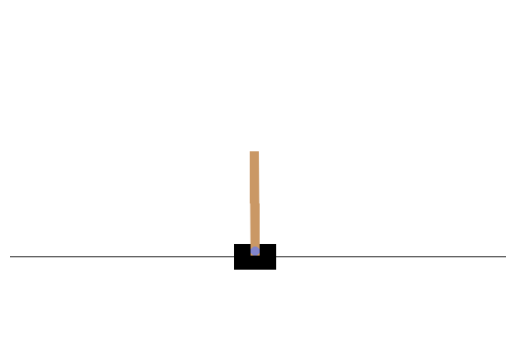

In [14]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots()
# Display the first frame initially
im = ax.imshow(frames[0])

# Turn off axes for a cleaner look
ax.axis('off')

def init():
    """
    Initialize the animation by displaying the first frame.
    """
    im.set_data(frames[0])
    return [im]

def update(frame):
    """
    Update the data in the imshow for each frame in `frames`.
    """
    im.set_data(frame)
    return [im]

ani = animation.FuncAnimation(
    fig,
    update,
    frames=frames,
    init_func=init,
    interval=50,   # Delay between frames in milliseconds
    blit=True      # Use blitting for better performance
)


In [15]:
HTML(ani.to_jshtml())


## Resumen

En este cuaderno, experimentamos con Gymnasium y sus numerosos entornos para practicar.  
Estudiamos su API básica y creamos un agente con un comportamiento aleatorio.  
También aprendiste cómo renderizar la actividad de nuestro agente utilizando *wrappers*.  

## References
[1] Lapan, M. (2024). Deep reinforcement learning hands-on. Packt Publishing Ltd.
[2] Fast Deep RL. https://courses.dibya.online/